In [1]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import cytoolz

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

import collections
import opt_einsum as oe
import itertools
import copy


In [2]:
import sys, os
sys.path.insert(0, '../')
# My functions
from TNutils import *


In [3]:
def meanpool2d_gs(npmnist, shape):
    '''
    Apply a meanpool convolution of an array of images (flattened)
    meanpool has kernel size 2x2
    '''
    ds_imgs = []
    for img in npmnist:
        ds_img = []
        for col in range(0,shape[0],2):
            for row in range(0,shape[1],2):
                pixel = np.mean([img.reshape(shape)[col,row], img.reshape(shape)[col,row+1],
                                 img.reshape(shape)[col+1,row], img.reshape(shape)[col+1,row+1]])
                
                ds_img.append(pixel)

        ds_imgs.append(np.array(ds_img).reshape((shape[0]//2)*(shape[1]//2)) )
        
    ds_imgs = np.array(ds_imgs)
    
    return ds_imgs

In [4]:
def get_data_gs(train_size = 1000, test_size = 100, grayscale_threshold = .5, reduced = False):
    '''
    Prepare the MNIST dataset for the training algorithm:
     * Choose randomly a subset from the whole dataset
     * Flatten each image to mirror the mps structure
     * Normalize images from [0,255] to [0,1]
     * Apply a threshold for each pixels so that each value 
       below that threshold are set to 0, the others get set to 1.
       For this algorithm we will only deal to binary states {0,1}
       instead of a range from 0 to 1    
    '''
    # Download all data
    mnist = torchvision.datasets.MNIST('classifier_data', train=True, download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]) )
    
    # Convert torch.tenor to numpy
    npmnist = mnist.data.numpy()
    
    # Check of the type of the sizes
    #if ((type(train_size) != int) or (type(test_size) != int)):
    #    raise TypeError('train_size and test_size must be INT')
    
    # Check if the training_size and test_size requested are bigger than
    # the MNIST whole size
    if ( (train_size + test_size) > npmnist.shape[0] ):
        raise ValueError('Subset too big') 
    
    # Check of the positivity of sizes
    if ( (train_size <= 0) or (test_size <= 0) ):
        raise ValueError('Size of training set and test set cannot be negative')
    
    # Choose just a subset of the data
    # Creating a mask by randomly sampling the indexes of the full dataset
    subset_indexes = np.random.choice(np.arange(npmnist.shape[0]), size=(train_size + test_size), 
                                      replace=False, p=None)
    
    # Apply the mask
    npmnist = npmnist[subset_indexes]

    # Flatten every image
    npmnist = np.reshape(npmnist, (npmnist.shape[0], npmnist.shape[1]*npmnist.shape[2]))
    
    # Normalize the data from 0 - 255 to 0 - 1
    npmnist = np.array(npmnist/npmnist.max() )
    
    if reduced:
        npmnist = meanpool2d_gs(npmnist, (28,28))
        
    return npmnist[:train_size], npmnist[train_size:]

In [5]:
train_set, test_set = get_data_gs(reduced = False)

In [6]:
train_size = 400
period_epochs = 3
periods = 5
shape = (28,28)

batch_size = 400
max_bond = 350

In [7]:
train_set = np.array(train_set)[:train_size]

In [8]:
train_set.shape

(400, 784)

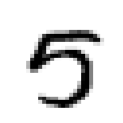

In [9]:
plot_img(train_set[0], shape)

In [10]:
def stater(x,i):
    if x <= 1 and x >= 0:
        vec = [x, 1-x]/np.sqrt(2*x**2 + 1 - 2*x)
        return qtn.Tensor(vec,inds=(f'v{i}',))
    return None

def tens_picture(picture):
    '''Converts an array of bits into a list of tensors compatible with a tensor network.'''
    tens = [stater(n,i) for i, n in enumerate(picture)]
    return np.array(tens)

In [11]:
# Convert accordingly
_imgs = np.array([tens_picture(img) for img in train_set])

# Initialize MPS
mps = initialize_mps(_imgs.shape[1])

# Initialize the cache
img_cache = left_right_cache(mps,_imgs[:])

sav_lr = mps_lr(mps, 0.08, 0.5, 0.05)
update_wrap = lambda site, div: sav_lr.J(site, div)


In [12]:
imgs = train_set

In [13]:
inds_dict = {'left': imgs.shape[1]*[None], 'right': imgs.shape[1]*[None], 'mps': imgs.shape[1]*[None], 'imgs': imgs.shape[1]*[None]}

In [14]:
torch_mps   = torchized_mps(mps,inds_dict)
torch_imgs  = torchized_imgs(_imgs,inds_dict)
torch_cache = torchized_cache(torch_mps,torch_imgs,inds_dict)

epoch 1/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 53.074384765625 | Baseline: 5.991464547107982
epoch 2/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 28.96364013671875 | Baseline: 5.991464547107982
epoch 3/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 22.2176806640625 | Baseline: 5.991464547107982


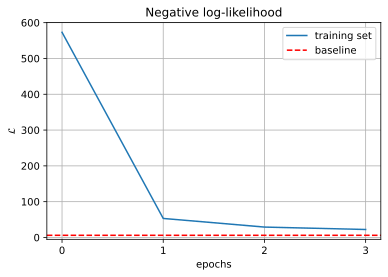

epoch 1/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 19.09431884765625 | Baseline: 5.991464547107982
epoch 2/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 17.39589111328125 | Baseline: 5.991464547107982
epoch 3/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 16.4328466796875 | Baseline: 5.991464547107982


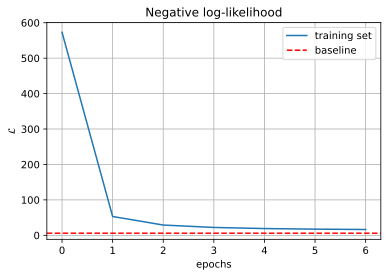

epoch 1/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 15.846328125 | Baseline: 5.991464547107982
epoch 2/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 15.44523681640625 | Baseline: 5.991464547107982
epoch 3/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 15.180120849609375 | Baseline: 5.991464547107982


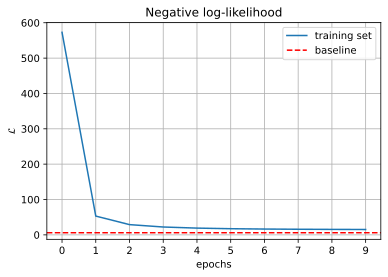

epoch 1/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 14.99489990234375 | Baseline: 5.991464547107982
epoch 2/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 14.854407958984375 | Baseline: 5.991464547107982
epoch 3/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 14.74537841796875 | Baseline: 5.991464547107982


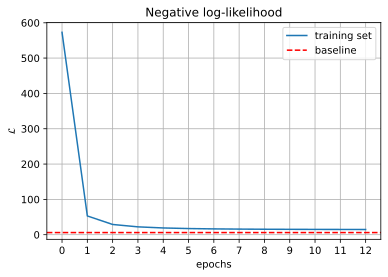

epoch 1/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 14.6650048828125 | Baseline: 5.991464547107982
epoch 2/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 14.6025 | Baseline: 5.991464547107982
epoch 3/3


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 14.5554931640625 | Baseline: 5.991464547107982


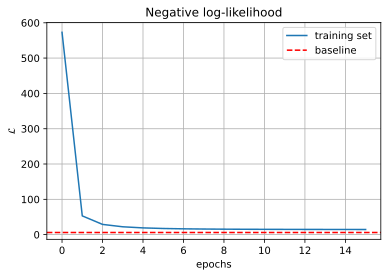

FileNotFoundError: [Errno 2] No such file or directory: './T400_L784//gen_imgs/right_bdim.svg'

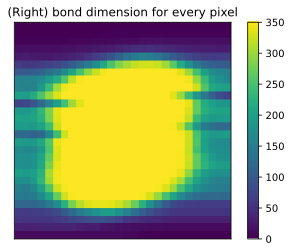

In [15]:
costs, samples = training_and_probing_torched(
    period_epochs,
    periods,
    mps,
    inds_dict,
    torch_mps,
    shape,
    imgs,
    _imgs,
    torch_imgs,
    torch_cache,
    batch_size,
    0.08,#sav_lr,
    #update_wrap = update_wrap,
    lr_update = lambda x: x*0.95,#lr_update = lr_update,
    val_imgs = [],
    period_samples = 0,
    corrupted_set = None,
    plot = True,
    max_bond = max_bond
    )


In [196]:
def generate_sample_gs(mps, N, rep):
    
    # We right canonize because at the end of training the MPS should be right canonized
    mps.right_canonize()
    
    # First pixel
    #            + I0----+
    # half contr | |     |
    #            + v0    |
    #              v0    |
    #              |     |    
    #              I0----+
    # To reach efficiency, we gradually contract half_contr with 
    # the other tensors
    # Contract v0 to I0
    
    # For the first contraction, we must take into account
    # the mps may not be normalized 
    # for all the other one we have ratios of probabilities 
    # and normalization will not matter
    gen_img = []
    Z = mps @ mps
    pixels = np.repeat(np.linspace(0,1,N),rep)
    
    pixel_res = []
    for pixel in pixels:
        half_contr = qtn.tensor_contract(stater(pixel,0), mps.tensors[0]).data
        p0 =  half_contr @ half_contr / Z
        if np.random.rand() < p0:
            pixel_res.append(pixel)
        
    end_pixel = np.mean(pixel_res)
    print(end_pixel)
    gen_img.append(end_pixel)
    previous_contr = qtn.tensor_contract(stater(end_pixel,0), mps.tensors[0]).data
    previous_at_previous = previous_contr @ previous_contr
    
    for index in range(1,len(mps.tensors)-1):
        pixel_res = []
        for pixel in pixels:
            # Contract vK to IK
            new_contr = qtn.tensor_contract(stater(pixel,index), mps.tensors[index]).data
            # Contract new_contr to the contraction at the previous step
            #   previous_contr--O
            #                   |  => previous_contr -- new_contr
            #                   vK
            new_contr = np.einsum('ba,b', new_contr, previous_contr)
    
            p = (new_contr @ new_contr)/previous_at_previous
            if np.random.rand() < p:
                pixel_res.append(pixel)
        
        end_pixel = np.mean(pixel_res)
        gen_img.append(end_pixel)
        
        # Contract [1,0] instead of [0,1]
        new_contr = qtn.tensor_contract(stater(end_pixel,index), mps.tensors[index]).data
        previous_contr = np.einsum('ba,b', new_contr, previous_contr)
        
        previous_at_previous = previous_contr @ previous_contr
        
    # Last pixel
    pixel_res = []
    index = index + 1
    for pixel in pixels:
        new_contr = qtn.tensor_contract(stater(pixel,index), mps.tensors[index]).data
        new_contr = new_contr @ previous_contr
    
        p = (new_contr**2)/(previous_at_previous)
        if np.random.rand() < p:
            pixel_res.append(pixel)
            
    end_pixel = np.mean(pixel_res)
    gen_img.append(end_pixel)
        
    return gen_img

In [194]:
def generate_sample_gs(mps, measurements = 10):
    '''
    Generate a sample from an MPS.
    0. normalize the mps (probabilities need to be computed)
    1. right canonize the mps (to easily compute the conditional probabilities
    2. Starting from the fist pixel (v0):
                                              __                        _ _
                                I0---+       |     I0---+       I0---+     |
                                 |   |    /  |     |    |       |    |     |
                               [0,1] |   /   |    [0,1] |  +   [1,0] |     |
      2.1 P(v0 = [0,1]) =      [0,1] |  /    |    [0,1] |      [1,0] |     |
                                 |   | /     |     |    |       |    |     |
                                I0---+       |__   I0---+       I0---+   __|
                                 
          (The denominator are the sum of probabilities that 
           saturates the state space, the sum of their probabilities,
           being the MPS normalized, is just 1.
           
        2.1.1 Compute the probability of V0 being [0,1] then draw a random
              number between 0 and 1, if the random number is less than
              the probabiity computed v0 becomes [0,1], else [1,0]
              
              v0 then becomes either [0,1] or [1,0] (for the next steps too)
         
         
                                  
      2.k P(vK = [0,1]| v{K-1}, ..., v0) = P(vK, v{K-1}, v0) / P(v{K-1}, ..., v0) =
      
             =   I0---...-I{K-1}---I{K+1}---+         I0---...---I{K-1}
                 |        |        |        |     /   |              |
                 v0       v{K-1}   v{k+1}   |    /    v0         v{K-1}
                 v0       v{K-1}   v{k+1}   |   /     v0         v{K-1}
                 |        |        |        |  /      |              |
                 I0---...-I{K-1}---I{K+1}---+         I0---...---I{K-1}
                 
        2.k.1 Compute the probability of vK being [0,1] then draw a random
              number between 0 and 1, if the random number is less than
              the probabiity computed vK becomes [0,1], else [1,0]
              
              vK then becomes either [0,1] or [1,0] (for the next steps too)
              
       .
       .
       .
    '''
    
    
    
    # Canonicalize right
    # We use the property of canonicalization to easily write
    # conditional probabilities
    # By right canonicalizing we will sample from left (1st pixel)
    # to right
    
    # We right canonize because at the end of training the MPS should be right canonized
    mps.right_canonize()
    
    # First pixel
    #            + I0----+
    # half contr | |     |
    #            + v0    |
    #              v0    |
    #              |     |    
    #              I0----+
    # To reach efficiency, we gradually contract half_contr with 
    # the other tensors
    # Contract v0 to I0
    
    # For the first contraction, we must take into account
    # the mps may not be normalized 
    # for all the other one we have ratios of probabilities 
    # and normalization will not matter
    half_contr = np.einsum('a,ba', [0,1], mps.tensors[0].data)
    p0 =  half_contr @ half_contr 
    half_contr1 = np.einsum('a,ba', [1,0], mps.tensors[0].data)
    p1 = half_contr1 @ half_contr1
    
    spin_d = 0
    for i in range(measurements):
        if np.random.rand() < (p0/(p0+p1)):
            spin_d = spin_d + 1
    
    end_pixel = spin_d / measurements
    print(end_pixel)
    gen_img = [end_pixel]
    # We need to reconstruct half_contr that will be used for the
    # next pixel
    # Contract v0 to I0
    half_contr = qtn.tensor_contract(stater(end_pixel,0), mps.tensors[0]).data
    previous_contr = half_contr
        
    for index in range(1,len(mps.tensors)-1):
        # Contract vK to IK
        new_contr = np.einsum('a,bca->bc', [0,1], mps.tensors[index].data)
        # Contract new_contr to the contraction at the previous step
        #   previous_contr--O
        #                   |  => previous_contr -- new_contr
        #                   vK
        new_contr = np.einsum('ba,b', new_contr, previous_contr)
    
        p = (new_contr @ new_contr)/(previous_contr @ previous_contr)
        
        spin_d = 0
        for i in range(measurements):
            if np.random.rand() < p:
                spin_d = spin_d + 1
        
        end_pixel = spin_d / measurements
        gen_img.append(end_pixel)
        
        new_contr = qtn.tensor_contract(stater(end_pixel,index), mps.tensors[index]).data
        new_contr = np.einsum('ba,b', new_contr, previous_contr)
            
        previous_contr = new_contr
    
    # Last pixel
    new_contr = np.einsum('a,ba', [0,1], mps.tensors[-1].data)
    new_contr = new_contr @ previous_contr
    
    p = (new_contr**2)/(previous_contr @ previous_contr)
    
    spin_d = 0
    for i in range(measurements):
        if np.random.rand() < p:
            spin_d = spin_d + 1
    
    gen_img.append(spin_d/measurements)
    
    return gen_img

In [237]:
a = generate_sample_gs(mps, 2, 2)

0.0


AttributeError: 'NoneType' object has no attribute 'inds'

In [ ]:
plot_img(a,(28,28))

In [221]:
imas = []

for i in range(5):
    imas.append( generate_sample_gs(mps, 2, 10) )
    

0.0
0.0
0.0
0.0
0.0


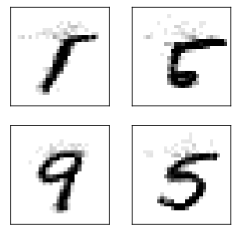

In [235]:
fig, ax = plt.subplots(2, 2, figsize=(4,4))
for i in range(2):
    for k in range(2):
        ax[k][i].imshow(1-np.array(imas[2*i+k]).reshape(shape), cmap='gray')
        ax[k][i].set_xticks([])
        ax[k][i].set_yticks([])
plt.savefig('./gen_gs.svg', format='svg')

0.0


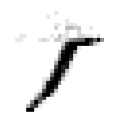

In [230]:
a = generate_sample_gs(mps, 2, 10)
plot_img(a,shape)

In [ ]:
a =